# SyriaTel Customer Churn

## Overview

The stakeholder is the telecom business. They interested in reducing how much money is lost because of customers who don't stick around very long. If we can accurately identify any patterns, we can minimize the turn rate for the company, and as a result decrease costs associated with losing and having to regrow its customer base. We will be delivering an analysis of what factors go into causing customer churn. Our stakeholder is not constrained to any particular model. We will be able to investigate several different types of models.<br>
In our context, a false positive is identifying someone will leave when they actually stay. Alternatively, a false negative would be identifying someone who will stay but they will actually leave. A false negative is much worse for our stakeholders because missing customers that will leave defeats the purpose of the analyzing this data set and developing the model. Missing these customers costs the company more money than a false positive. For thsi reason we will need to optomize our recall score for the models.

## Data Understanding
The data comes from SyriaTel and includes information about their customers. The dataset has customer's state of residence, telephone numbers and length of the account. There are columns indicating if the customer has an international plan and voicemail plan, how many voice mails they receive. The dataset includes how many minutes they spend talking, how many calls they make and how much they are charged during day, evening and night periods. Additionally, the data inlcudes how many customer service calls each customer has made. And, the target variable, the customer's churn status. For our analysis, we will focus on the number of customer service calls each customer makes, what is each customer's total bill and if it affects the likelihood of churn and which states have the highest turn rate.

## Data Preparation
Overall, this data set is very clean. There are no missing values or NaNs to handle. We have dropped the area code and phone numbers for the privacy of the customer. We have added the total number of domestic minutes, calls and charges to gauge the total bill's affect on turn rate. As well as sorting the states into different chur rate categories.

## Exploring the data

In [9]:
#needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [10]:
#import data
df = pd.read_csv("data/bigml_59c28831336c6604c800002a.csv")
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [11]:
#drop phone numbers and area code for privacy concerns
#We will use state data for analysis rather than the area codes
df = df.drop(["phone number", "area code"], axis = 1)
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [12]:
df.shape

(3333, 19)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   object 
 3   voice mail plan         3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

This data set is small, but very clean. There are no missing values to handle.

Let's look at what the churn rate is over the data set. We are dealing with a very imbalanced data set. We will most likely need to use SMOTE to over sample data when modeling.

In [14]:
df["churn"].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

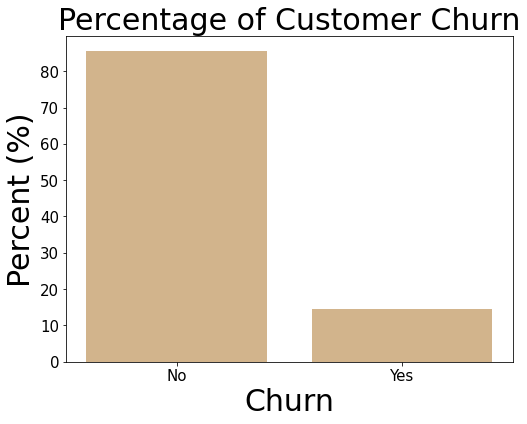

In [15]:
#Let's visualize the churn rate
fig,ax = plt.subplots(figsize=(8,6))
plt.bar(x = df["churn"].unique(), height = round(df["churn"].value_counts(normalize=True)*100, 2), color= "tan")
plt.xticks(ticks=[0,1], labels=["No", "Yes"], fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel("Churn", fontsize = 30)
ax.set_ylabel("Percent (%)", fontsize = 30)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Percentage of Customer Churn",fontsize = 30)
plt.show()

## Feature Eningeering
Rather than writing code over and over I wrote this simple code to add multiple columns and output a new column to the dataset.

In [16]:
def combine(name, *cols):
    "This function will name a new column and add as many columns as necessary"
    df[name] = sum(cols)

In [17]:
#Let's find total domestic minutes for each customer.
combine("total_domestic_minutes", 
        df["total day minutes"], 
        df["total eve minutes"], 
        df["total night minutes"])

#Let's find total domestic calls for each customer.
combine("total_domestic_calls", 
        df["total day calls"], 
        df["total eve calls"], 
        df["total night calls"])

#Let's find total domestic charges for each customer.
combine("total_domestic_charge", 
        df["total day charge"], 
        df["total eve charge"], 
        df["total night charge"])

#Let's find total charges for each customer.
combine("total_charge", 
        df["total_domestic_charge"], 
        df["total intl charge"])

## State Turn Rate
We wanted to investigate what the states had the highest turn rates. 

In [18]:
#groups states and looks at churn and not turn rates 
states = df.groupby('state')['churn'].value_counts(normalize=True)
states = pd.DataFrame(states)
states.columns = ['percent']
states = states.reset_index()
states

,state,churn,percent
0,AK,False,0.942308
1,AK,True,0.057692
2,AL,False,0.900000
3,AL,True,0.100000
4,AR,False,0.800000
...,...,...,...
97,WI,True,0.089744
98,WV,False,0.905660
99,WV,True,0.094340
100,WY,False,0.883117


In [19]:
#looks at churn rates of each state
states_churn_rate = states.loc[states['churn'] == True].sort_values("percent", ascending =False)\
                                                        .reset_index().drop("index", axis =1)
states_churn_rate

,state,churn,percent
0,NJ,True,0.264706
1,CA,True,0.264706
2,TX,True,0.250000
3,MD,True,0.242857
4,SC,True,0.233333
5,MI,True,0.219178
6,MS,True,0.215385
7,NV,True,0.212121
8,WA,True,0.212121
9,ME,True,0.209677


In [20]:
#looking at the sorted churn rates we noticed some points where we could divide the data
#this cell assigns states to a high turn category.
#20% percent is alot of churn
high_churn = states_churn_rate.loc[states_churn_rate['percent'] >= .2]
high_churn_states = list(high_churn['state'])
high_churn_states

['NJ', 'CA', 'TX', 'MD', 'SC', 'MI', 'MS', 'NV', 'WA', 'ME', 'MT', 'AR']

In [21]:
#we first tried to split the data between 20% and 10 % but the category was to large, 
#we wanted to find more evenness in the splits, so we split at 15%
med_churn = states_churn_rate.loc[(states_churn_rate['percent'] < .2) & (states_churn_rate['percent'] >= .15)]
med_churn_states = list(med_churn['state'])
med_churn_states

['KS', 'NY', 'MN', 'PA', 'MA', 'CT', 'NC', 'NH']

In [22]:
#finishing the "medium" split
medlow_churn = states_churn_rate.loc[(states_churn_rate['percent'] < .15) & (states_churn_rate['percent'] >= .1)]
medlow_churn_states = list(medlow_churn['state'])
medlow_churn_states

['GA',
 'DE',
 'OK',
 'OR',
 'UT',
 'CO',
 'KY',
 'SD',
 'OH',
 'FL',
 'IN',
 'ID',
 'WY',
 'MO',
 'VT',
 'AL']

In [23]:
#finish the split
low_churn = states_churn_rate.loc[states_churn_rate['percent'] < .1]
low_churn_states = list(low_churn["state"])
low_churn_states

['NM',
 'ND',
 'WV',
 'TN',
 'DC',
 'RI',
 'WI',
 'IL',
 'NE',
 'LA',
 'IA',
 'VA',
 'AZ',
 'AK',
 'HI']

In [24]:
def categorize(state):
    #Code found at:
    #https://github.com/tiaplagata/dsc-phase-3-project/blob/main/Notebooks/EDA.ipynb
    """assigns states to high, medium, medium-low and low churn rate categories
    
    returns a the state now assigned to a category"""
    
    if state in high_churn_states:
        state = "high"
    elif state in med_churn_states:
        state = "med"
    elif state in medlow_churn_states:
        state = "med-low"
    else:
        state ="low"
    return state

def competition(df):
    
    """applies the categorize function to a new column named state, assigns the modified column to  a new 
    category called 'churn_rate' 
    
    returns the data frame with the new column"""
    
    df["churn_rate"] = df["state"].apply(categorize)
    return df

In [25]:
#runs the function, expanded dataset!
competition(df)

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


### Further Data investigation can be found in the Exploratory Data Anaylsis Notebook

# Modeling
As we devlop our models, we will be optomizing the recall score of our models. As a reult, we may identify more people as leaving, but in reality they stay. The company will spend some resources to retain the customer. However, that the cost of keeping them engaged with the company far outweighs the cost of identifying someone as staying and in actuality they leave the company. The company would lose a customer and then have to spend more resources to get a new customer in their place.<br>

This function will help us evaluate our models.

In [26]:
#evaluate function
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [27]:
#A qucik look at our dataframe
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


## Model-less evaluation

In [28]:
df["churn"].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

The model would only be right 14.5% of the time if the model only guessed every customer would leave.

## Pipeline
We will build a pipeline to make preprocessing our data and running model easier than coding everything anew with every model.

In [29]:
#splits our data set to features and the target "churn"
X = df.drop(["churn"], axis = 1)
y= df["churn"]
#this seed will ensure we use the same random_state in all of our modeling
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [30]:
#what does our training data look like?
X_train.shape

(2249, 23)

In [31]:
# organize columns for the pipeline
num_cols = []
ohe_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        ohe_cols.append(c)

In [32]:
print(num_cols)
print(ohe_cols)

['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'total_domestic_minutes', 'total_domestic_calls', 'total_domestic_charge', 'total_charge']
['state', 'international plan', 'voice mail plan', 'churn_rate']


In [33]:
#take all numerical featurres and runs them through a Simple Imputer. 
#Although we are not missing any values, we want to ensure all columns are in the pipeline 
nums = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

#Takes all categorical variables and OneHotEncodes them
ohe = Pipeline(steps=[
    ("ohe_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])


In [34]:
#builds our preprocessor step using a ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", nums, num_cols),
        ("ohe", ohe, ohe_cols)
    ])

In [35]:
#ensures all of features go through the correct steps during preprocessing
preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls',
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                       

## Logistic Regression
The first model will be a logistic regression model, then we will tune some hyperparameters

In [36]:
#features move through the preprocessing pipeline, then we oversample to address the class imbalance,
#then we scale the data using MaxAbsScaler because of our sparse data set, finally we run the model
logreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

In [37]:
#fits the data to the pipeline
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [38]:
cross_validate(logreg, X_train, y_train, return_train_score=True, scoring="recall")

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'fit_time': array([0.17602277, 0.15792823, 0.13100934, 0.21230125, 0.14704704]),
 'score_time': array([0.01299739, 0.01499939, 0.01400614, 0.01900244, 0.0150919 ]),
 'test_score': array([0.625     , 0.6875    , 0.67692308, 0.70769231, 0.71875   ]),
 'train_score': array([0.74031008, 0.75581395, 0.74708171, 0.74319066, 0.75581395])}

The model stopped at the total number of iterations and could not complete its analysis. This will be adjusted when we tune the hyperparameters.

Training Scores:
Train Accuracy: 0.791907514450867
Train Precision: 0.38522012578616355
Train Recall: 0.7608695652173914
Train F1-Score: 0.511482254697286
ROC-AUC: 0.8381434792278412
**********
Testing Scores:
Test Accuracy: 0.768
Test Precision: 0.3333333333333333
Test Recall: 0.6111111111111112
Test F1-Score: 0.43137254901960786
ROC-AUC: 0.77466251298027


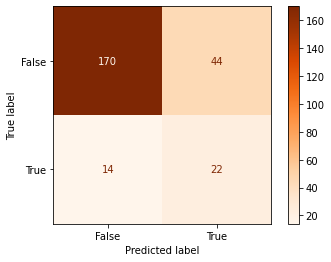

In [39]:
evaluate(logreg, X_train, X_test, y_train, y_test, roc_auc='proba')

The evaluation function shows the does not perform very well. While precision metric is not the most important, its still must be accounted for in deciding what model to use. The recall score dropped quite a bit meaning the model is failing to caputure churned customers.

## Logistical Regression with Tuning

In [40]:
logreg_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ("scaler", MaxAbsScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

In [41]:
#here we will adjust the max iterations, penalty, the regulation power 
#and use a liblinear solver due to the choices in penalty and the size of the data set
param_grid = {
    'classifier__max_iter': [1000, 10000, 100000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [1, 5, 10, 100],
    'classifier__solver': ["liblinear"]
}

In [42]:
grid = GridSearchCV(logreg_tuned, param_grid)

In [43]:
output = grid.fit(X_train, y_train)

In [44]:
#best parameters based on the grid search
output.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

Training Scores:
Train Accuracy: 0.7927967985771454
Train Precision: 0.3864353312302839
Train Recall: 0.7608695652173914
Train F1-Score: 0.5125523012552301
ROC-AUC: 0.8378485529271839
**********
Testing Scores:
Test Accuracy: 0.768
Test Precision: 0.3333333333333333
Test Recall: 0.6111111111111112
Test F1-Score: 0.43137254901960786
ROC-AUC: 0.7728452751817239


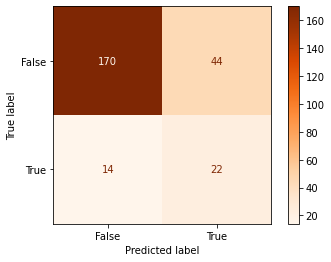

In [45]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

The tuned model performed the same as the untuned model. This may be caused by the number of features we use for model. There may some multicollinearity issues causing poor performance. Considering time constraints we will move on to the next model. 

## Decision Tree

In [46]:
#we will follow the same steps as before, but without the scaling step.
#Decision trees do not need scaling because they are nonparametric
dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [47]:
dt.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [48]:
cross_validate(dt, X_train, y_train, return_train_score=True, scoring="recall")

{'fit_time': array([0.12754941, 0.14052653, 0.14231825, 0.1145606 , 0.1275022 ]),
 'score_time': array([0.01500297, 0.01699805, 0.01151204, 0.01738453, 0.01299214]),
 'test_score': array([0.78125   , 0.890625  , 0.81538462, 0.86153846, 0.859375  ]),
 'train_score': array([1., 1., 1., 1., 1.])}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.948
Test Precision: 0.8484848484848485
Test Recall: 0.7777777777777778
Test F1-Score: 0.8115942028985507
ROC-AUC: 0.8772066458982347


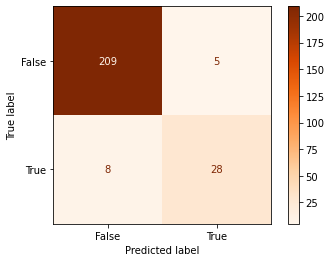

In [49]:
evaluate(dt, X_train, X_test, y_train, y_test, roc_auc='proba')

Like the other untuned models, this model is very overfit. With so many parameters and no max depth set the model goes down as far as it can resulting in the overfitting.

## Decision Tree with Tuning

In [50]:
dt_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [51]:
#For this tuned model, we decided to adjust for the max depth to prevent over fitting
#additionally we wanted to adjust the number of samples needed to split internal nodes 
#by trying to constrain the model a bit more.
#and, we adjusted the min_samples_leaaf parameter to prevent the tree from splitting nodes to far down. 
param_grid = {
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__min_samples_split": [2, 3, 5,10],
    "classifier__min_samples_leaf": [2, 3, 5,10]
}

In [52]:
grid_dt = GridSearchCV(dt_tuned, param_grid)

In [53]:
output = grid_dt.fit(X_train, y_train)

In [54]:
output.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2}

Training Scores:
Train Accuracy: 0.9764339706536238
Train Precision: 0.996309963099631
Train Recall: 0.8385093167701864
Train F1-Score: 0.9106239460370995
ROC-AUC: 0.9392814434950217
**********
Testing Scores:
Test Accuracy: 0.968
Test Precision: 0.9666666666666667
Test Recall: 0.8055555555555556
Test F1-Score: 0.8787878787878789
ROC-AUC: 0.9069963655244029


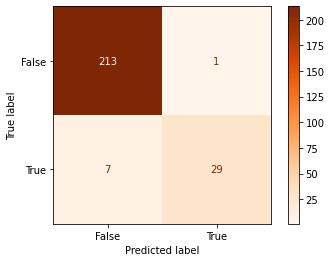

In [55]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

This model is the best performing model yet. Accurancy is maintained, and there is only a slight drop in the recall score. These score shows the model is fitting the testing data well and able to generalize to the testing data.

## Final Model

After running Logistic Regression, KNearest Neighbors, Decsion Tree and XGBoost models and after tuning the hyperparameters to improve performance, we have determined the best performing model is the tuned Decsion Tree. We will use this model to test on our hold out set. To prevent data leakage, the hold out set has not been touched by any of our previous modeling. 

In [56]:
#here we pull up data split for the final model to work on.
X = df.drop(["churn"],axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2, random_state=seed)

In [57]:
dt_final = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(max_depth = 5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          random_state=seed))
])
dt_final.fit(X_use, y_use)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

Training Scores:
Train Accuracy: 0.976325441813938
Train Precision: 0.9890710382513661
Train Recall: 0.8438228438228438
Train F1-Score: 0.910691823899371
ROC-AUC: 0.9381341616260694
**********
Testing Scores:
Test Accuracy: 0.9730538922155688
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.9487840825350038


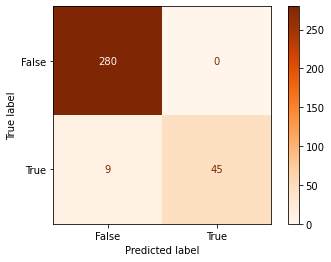

In [58]:
evaluate(dt_final, X_use, X_hold, y_use, y_hold, roc_auc='proba')

We are very pleased with performance of the tuned Decision Tree on the hold out dataset. The precision and recall scores are high on the training and testing data. There is a 1 % percent drop in recall performance but this is a small reduction. Our model is very picky about who it idemtifies and it is very good at classifying the curn status of a customer.

### More models can be found in the Modeling Notebook

## Feature Importance
Here we will go into our model and pull out what features carried the most weight in making decisions when splitting the nodes.

In [59]:
#size of our holdout training data
dt_final["preprocess"].fit_transform(X_use).shape

(2999, 78)

In [60]:
pd.DataFrame(dt_final["preprocess"].fit_transform(X_train)).head()

,0
0,"(0, 0)\t145.0\n (0, 2)\t199.2\n (0, 3)\t12..."
1,"(0, 0)\t179.0\n (0, 2)\t170.7\n (0, 3)\t54..."
2,"(0, 0)\t98.0\n (0, 2)\t126.3\n (0, 3)\t102..."
3,"(0, 0)\t10.0\n (0, 2)\t222.2\n (0, 3)\t127..."
4,"(0, 0)\t66.0\n (0, 1)\t36.0\n (0, 2)\t106...."


In [61]:
#raw feature importances
dt_final['classifier'].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.00043856,
       0.00158743, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0004478 , 0.02384175, 0.03858705, 0.21093487,
       0.        , 0.        , 0.        , 0.33613922, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00368791, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28320127, 0.00507589, 0.        , 0.04265221, 0.05340

In [62]:
#list numerical features in our model
num_cols_final = dt_final['preprocess'].transformers_[0][2]
num_cols_final

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge']

In [63]:
#list of categorical features in our model
ohe_cols_transformed = dt_final['preprocess'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
       'state_WY', 'international plan_no', 'international plan_yes',
       'voice mail plan_no', 'voice mail plan_yes', 'churn_rate_high',
       'churn_rate_low', 'churn_rate_med', 'churn_rate_med-low'],
      dtype=object)

In [64]:
#complete list of features in our model
final_cols =[*num_cols_final, *ohe_cols_transformed]
final_cols

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',


In [65]:
#joing the features and weights and organizing them in descending order.
features = pd.DataFrame.from_dict(dict(zip(final_cols, dt_final['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False).head(10).reset_index()
features

,index,0
0,total_charge,0.336139
1,international plan_no,0.283201
2,customer service calls,0.210935
3,churn_rate_high,0.053406
4,voice mail plan_yes,0.042652
5,total intl charge,0.038587
6,total intl calls,0.023842
7,international plan_yes,0.005076
8,state_LA,0.003688
9,total eve minutes,0.001587


In [66]:
#This code is found at :
#https://scikit-learn.org/stable/auto_examples/tree/
#plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
n_nodes = dt_final["classifier"].tree_.node_count
children_left = dt_final["classifier"].tree_.children_left
children_right = dt_final["classifier"].tree_.children_right
feature = dt_final["classifier"].tree_.feature
threshold = dt_final["classifier"].tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 33 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 18] <= 74.05419921875 else to node 22.
	node=1 is a split node: go to node 2 if X[:, 70] <= 0.9999057948589325 else to node 9.
		node=2 is a split node: go to node 3 if X[:, 70] <= 0.0011587738990783691 else to node 8.
			node=3 is a split node: go to node 4 if X[:, 12] <= 2.988521695137024 else to node 5.
				node=4 is a leaf node.
				node=5 is a split node: go to node 6 if X[:, 13] <= 3.482963442802429 else to node 7.
					node=6 is a leaf node.
					node=7 is a leaf node.
			node=8 is a leaf node.
		node=9 is a split node: go to node 10 if X[:, 14] <= 3.0163464546203613 else to node 17.
			node=10 is a split node: go to node 11 if X[:, 74] <= 0.0010519216302782297 else to node 14.
				node=11 is a split node: go to node 12 if X[:, 37] <= 0.009047150611877441 else to node 13.
					node=12 is a leaf node.
					node=13 is a leaf node.
				node=14 is a split node: 

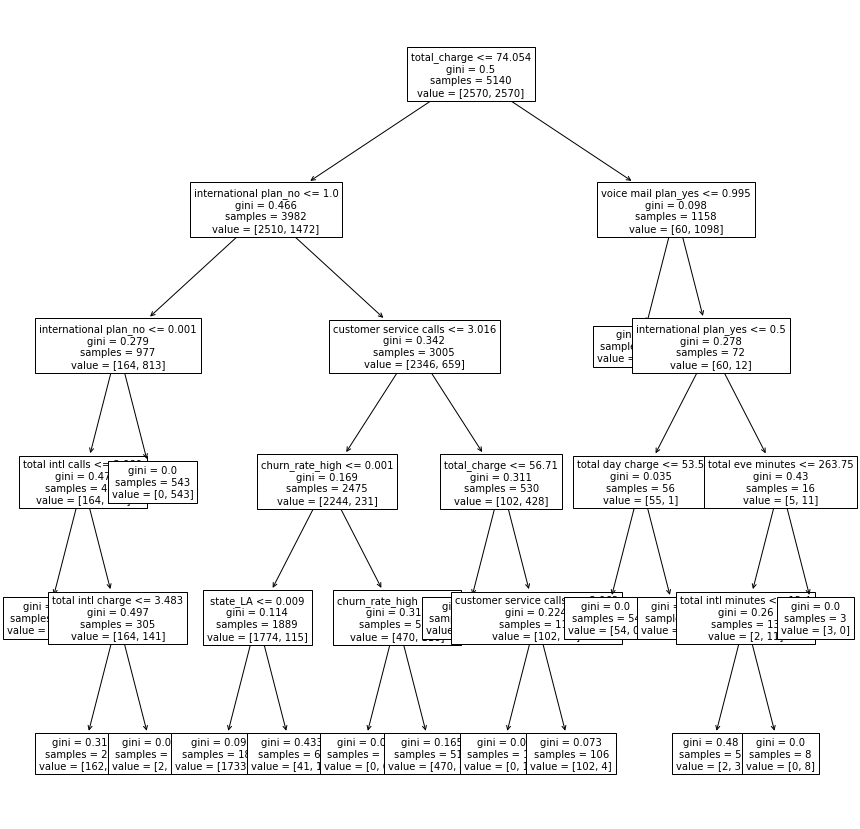

In [67]:
#visualizes the tree
fig, ax = plt.subplots(figsize=(15,15))
plot_tree(dt_final["classifier"], feature_names=final_cols, fontsize=10)
plt.show()

# Analysis
After reviewing the models and determining the most important feature. We went back to our dataset to analyze why they were so important. What made them so important?<br>
Futher analysis can be found in the Exploratory Data Analysis Notebook

## Churned customers vs retained customers
We decided to split the data set up to further investigate the differences between the groups.

In [68]:
#check the dataset
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


In [69]:
#create a new dataset with just the churned clients
churn = df[df["churn"] == 1]
churn

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
10,IN,65,no,no,0,129.1,137,21.95,228.5,83,...,12.7,6,3.43,4,True,566.4,331,50.77,54.20,med-low
15,NY,161,no,no,0,332.9,67,56.59,317.8,97,...,5.4,9,1.46,4,True,811.3,292,90.83,92.29,med
21,CO,77,no,no,0,62.4,89,10.61,169.9,121,...,5.7,6,1.54,5,True,441.9,274,34.48,36.02,med-low
33,AZ,12,no,no,0,249.6,118,42.43,252.4,119,...,11.8,3,3.19,1,True,782.2,327,76.49,79.68,low
41,MD,135,yes,yes,41,173.1,85,29.43,203.9,107,...,14.6,15,3.94,0,True,499.2,270,52.26,56.20,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,CA,84,no,no,0,280.0,113,47.60,202.2,90,...,10.4,4,2.81,0,True,639.0,306,71.85,74.66,high
3304,IL,71,yes,no,0,186.1,114,31.64,198.6,140,...,13.8,5,3.73,4,True,591.2,334,57.81,61.54,low
3320,GA,122,yes,no,0,140.0,101,23.80,196.4,77,...,9.7,4,2.62,4,True,456.5,311,45.89,48.51,med-low
3322,MD,62,no,no,0,321.1,105,54.59,265.5,122,...,11.5,2,3.11,4,True,767.1,299,85.28,88.39,high


In [70]:
# create a new dataset with just the remaining clients
not_churn = df[df["churn"] ==0]
not_churn

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,False,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,False,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,False,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,False,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,False,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,False,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,False,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,False,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,False,512.6,326,56.18,57.53,med


## Customer Service Calls
Our model indicated the number of customer service calls impacted where a customer would remain with the company or not.

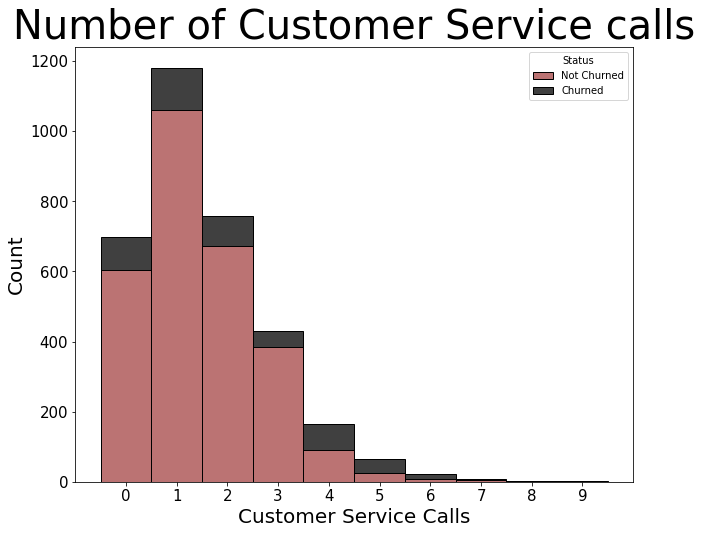

In [71]:
fig,ax = plt.subplots(figsize=(10,8))

bins = np.arange(11) - 0.5

ax = sns.histplot(
    df,
    x='customer service calls',
    hue='churn',
    multiple='stack',
    hue_order=[1,0],
    bins=bins,
    palette=['#0000', '#A44444']

)

ax.set_title('Number of Customer Service calls', fontsize = 40)
ax.set_xlabel("Customer Service Calls", fontsize = 20)
ax.set_ylabel("Count", fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(range(10), fontsize = 15)
plt.xlim([-1, 10])

ax.legend(title= "Status", labels = ["Not Churned", 'Churned'])

The graph shows a large drop off if customers service calls after 3 calls, but after that the proportion of people who left increased as the number of Customer Service calls increased. It would be adviasable to offere a discount if someone calls four times to help retain their business without offering to many people would stay otherwise.

## Total bill

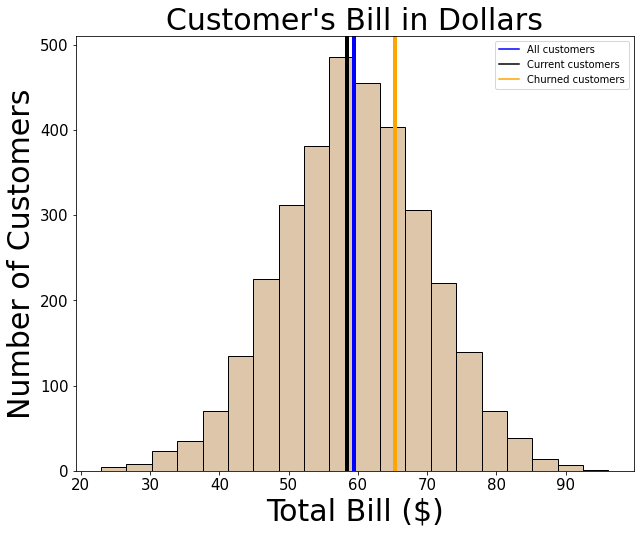

In [72]:
# Visualizing the differences
fig,ax = plt.subplots(figsize=(10,8))
sns.histplot(df["total_charge"], bins = 20, color= "tan")
# plt.show()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel("Total Bill ($)", fontsize = 30)
ax.set_ylabel("Number of Customers", fontsize = 30)
ax.set_title("Customer's Bill in Dollars",fontsize = 30)
plt.axvline(df["total_charge"].mean(), linewidth=4, color='blue')
plt.axvline(churn["total_charge"].mean(), linewidth=4, color='orange')
plt.axvline(not_churn["total_charge"].mean(), linewidth=4, color='black')


lgd = []
lgd.append(plt.axvline(df["total_charge"].mean(), color = 'blue', label = 'All customers'))
lgd.append(plt.axvline(not_churn["total_charge"].mean(), color = 'black', label = 'Current customers'))
lgd.append(plt.axvline(churn["total_charge"].mean(), color = 'orange', label = 'Churned customers'))

plt.legend(handles = lgd)
plt.show()
plt.show()

This graph shows the average for all customers is 59.45. The average bill for customer who were retained is 58.45. The average bill for customers who left is 65.36. That is nearly a 10 percent difference. Creating a flat rate option would entice those customers with higher bills to enroll in the program and remain with the company.

## High Churn States

In [74]:
#makes a dataframe with high states and their churn percent
high_churn = states_churn_rate.loc[states_churn_rate['percent'] >= .2]
high_churn_states = pd.DataFrame(high_churn[['state', "percent"]])
high_churn_states["percent"] = round(high_churn_states["percent"]*100, 2)
high_churn_states

,state,percent
0,NJ,26.47
1,CA,26.47
2,TX,25.00
3,MD,24.29
4,SC,23.33
5,MI,21.92
6,MS,21.54
7,NV,21.21
8,WA,21.21
9,ME,20.97


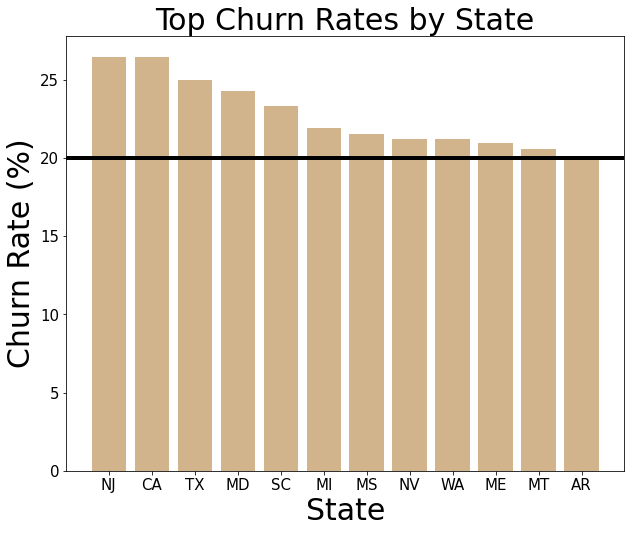

In [75]:
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x = high_churn_states["state"], height = high_churn_states["percent"], color = "tan")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel("State", fontsize = 30)
ax.set_ylabel("Churn Rate (%)", fontsize = 30)
ax.set_title("Top Churn Rates by State",fontsize = 30)
plt.axhline(y=20, linewidth=4, color='black')
plt.show()

SyriaTel loses 1 in 5 customers or more in each of these states. These are prime targets for marketing campaigns to rollout the new flatrate and customer service program to improve customer retention. 

### More granular analysis can be found in the Exploratory Data Analysis Notebook

# Business Solutions
Our tuned Decision Tree Model performs the best out of all our models. The model indicats three of the most important features to predicting customer churn are the number of customer service calls a customer makes, the cost of customers bill, and where the customer resides.<br><br>
Based on these factors, we recommend SyriaTel offeres a discount on teh fourth customer service call to avoid churn while providing great customer service, incorporates a flat rate program for clients to enroll to reduce high bill costs and create targeted marketing campaigns in states where SyriaTel is losing more than 20 percent of their customers. After implimenting these recommendations, SryiaTel should montior the effects of these programs on a quarterly basis to make needed adjustments in the marketplace.